In [ ]:
# This is a series of examples using the icanswim/qchem quantum mechanic machine learning repo
# icanswim/qchem utilizes the icanswim/cosmosis data science machine learning repo

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS
from cosmosis.learning import Learn, Selector

from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import pyg_model, GNet

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader


RDKit WARNING: [16:12:25] Enabling RDKit 2019.09.3 jupyter extensions


In [ ]:
ds_params = {'train_params': {'dataset': 'QM9',
                              'use_pyg': True,
                              'pg_params': {'root': './data/'}}}

pgds = PGDS(**ds_params['train_params'])
print(pgds[55967])
print(pgds[55967].num_node_features)
print(pgds[1])
print(pgds[1].num_node_features)
print(pgds[1].edge_index)

In [ ]:
loader = DataLoader(pgds, batch_size=2, shuffle=False)
for data in loader:
    print(data)
    break

In [ ]:
ds_params = {'train_params': {'dataset': 'QM9',
                              'use_pyg': False,
                              'pad': (29,11),
                              'pad_feats': ['x'],
                              'flatten': False,
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

pgds = PGDS(**ds_params['train_params'])
pgds[55967]

In [ ]:
ds_params = {'train_params': {'dataset': 'TUDataset',
                              'use_pyg': True,
                              'pg_params': {'root': './data/',
                                            'name': 'ENZYMES'}}}
pgds = PGDS(**ds_params['train_params'])
print(pgds[1])
print(pgds[2])

In [ ]:
model_params = {'in_channels': 319, 
                'hidden': 512, 
                'out_channels': 19, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'use_pyg': False,
                              'pad': (29,11),
                              'pad_feats': ['x'],
                              'flatten': True,
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

In [ ]:
model_params = {'in_channels': 11,  
                'out_channels': 1}

ds_params = {'train_params': {'dataset': 'QM9',
                              'use_pyg': True,
                              'pg_params': {'root': './data/'}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([PGDS], GNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=None, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=16, epochs=2)

In [ ]:
## Example using scikit dataset wrapper SKDS and custom model
model_params = {'in_channels': 128, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'make': 'make_regression',
                              'transform': [],
                              'target_transform': [],
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 128}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([SKDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

In [ ]:
## Example using QM7 dataset and custom model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['ae'],
                              'in_file': './data/qm7/qm7.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 3,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

In [ ]:
## Example using the QM7b dataset
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['E'],
                              'in_file': './data/qm7b/qm7b.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 3,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=20)

In [ ]:
## Find the longest molecule in the QM7X dataset

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) pad=23

ds_params = {'train_params': {'features': features,
                              'pad': 23,
                              'target': ['atNUM'],
                              'as_tensor': False,
                              #'embeds': [],
                              'selector': ['opt'],
                              'flatten': True}}

qm7x = QM7X(**ds_params['train_params'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, m)
print(qm7x[m]['X'].shape) 
qm7x[m]


In [ ]:
## Example using the QM7X dataset and custom model with embeddings
model_params = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_params = {'train_params': {'features': ['coulomb'],
                              'pad': 23,
                              'target': ['eAT'],
                              'selector': ['opt'],
                              'flatten': True,
                              'n': 1000}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=64, epochs=10)

In [ ]:
## Example using the QM9 dataset
model_params = {'in_channels': 14+23+23*23, 
                'hidden': 1024, 
                'out_channels': 1, 
                'model_name': 'funnel',
               }

ds_params = {'train_params': {#'n': 2000,
                              'db': 'qm9',
                              'n_conformers': 1,
                              'features': ['A','B','C','mu','alpha','homo','lumo', 
                                           'gap','r2','zpve','U','H','G','Cv',
                                           'mulliken','coulomb'],

                              'target': ['U0'],
                              'pad': 23,
                              'pad_feats': ['mulliken','coulomb'],
                              'as_tensor': True,
                              'use_pickle': False,
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 'subset': .1
                }

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=256, epochs=30)

In [ ]:
## Example using the QM9 dataset
model_params = {'in_channels': 14+23+23*23, 
                'hidden': 1024, 
                'out_channels': 1, 
                'model_name': 'funnel',
               }

ds_params = {'dataset': 'QM9',
             'features': ['x','edge_index','edge_attr','pos','z'],
             'targets': 'y',
             'flatten': True,
             'as_tensor': True,
             'pad': 23,
             'pad_feats'; [',
             'pg_params': {'root': './data/'}}

ds_params = {'train_params': {#'n': 2000,
                              'db': 'qm9',
                              'n_conformers': 1,
                              'features': ['A','B','C','mu','alpha','homo','lumo', 
                                           'gap','r2','zpve','U','H','G','Cv',
                                           'mulliken','coulomb'],

                              'targets': ['U0'],
                              'pad': 23,
                              'pad_feats': ['mulliken','coulomb'],
                              'as_tensor': True,
                              'use_pickle': False,
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 'subset': .1
                }

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([PGDS], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=256, epochs=30)

In [ ]:
## Example using the QM9 dataset with filter and rdkit data augmentation
model_params = {'in_channels': 6*23+23*23+11+23+16*23+16*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel',
                'embed_params': [('hybridization',9,16,0,True),('chirality',9,16,0,True)]
               }

rdkit_features = ['atomic_number','aromatic','degree',
                  'charge','n_hs','n_rads','coulomb']

rdkit_edge = ['edge_indices','edge_attr']

qm9_features = ['A','B','C','mu','alpha','homo','lumo','gap',
                'r2','zpve','Cv','mulliken']


ds_params = {'train_params': {'n': 2000,
                              'db': 'rdkit',
                              'n_conformers': 1,
                              'features': rdkit_features+qm9_features,
                              'embeds': ['hybridization','chirality'],
                              'targets': ['U0'],
                              'pad': 23,
                              'pad_feats': ['mulliken','coulomb','aromatic','degree',
                                            'charge','n_hs','n_rads','atomic_number',
                                            'hybridization','chirality'],
                              'as_tensor': True,
                              #'filter_on': ('n_atoms','<','18'),
                              'use_pickle': False,
                              'flatten': True}}


metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .1
                }

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=256, epochs=30)

creating QM9 dataset...
molecules scanned:  1
molecules removed for no rdkit conformer:  0
molecules removed for inconsistancy:  0
molecules created:  1
molecules scanned:  1001
molecules removed for no rdkit conformer:  15
molecules removed for inconsistancy:  0
molecules created:  986
total molecules scanned:  1015
total molecules removed for inconsistancy:  0
total molecules removed for no rdkit conformer:  15
total uncharacterized molecules removed:  26
total molecules created:  974
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:02.727789
epoch: 0, lr: 0.01
train loss: 261.3849044073196, val loss: 207.99016316731772
test loss: 34.70222473144531
learning time: 0:00:03.788053


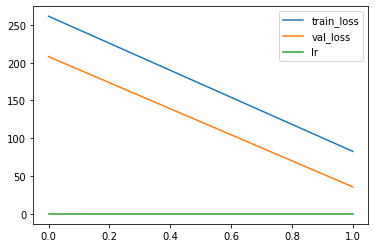

In [2]:
#test test
rdkit_features = ['atomic_number','aromatic','degree',
                  'charge','n_hs','n_rads','coulomb']

rdkit_edge = ['edge_indices','edge_attr']

qm9_features = ['A','B','C','mu','alpha','homo','lumo','gap',
                'r2','zpve','U0','U','H','G','Cv','mulliken']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atomic_number'],
                                                             'embed': ['hybridization']
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'n': 1000,
                              'db': 'rdkit',
                              'n_conformers': 1,
                              'pad': 23,
                              'pad_feats': ['mulliken','coulomb','aromatic','degree',
                                            'charge','n_hs','n_rads','atomic_number',
                                            'hybridization','chirality'],
                              'as_tensor': True,
                              #'filter_on': ('n_atoms','<','18'),
                              'use_pickle': False,
                              'flatten': True}}


model_params = {'in_channels': 23+23*16, 
                'hidden': 1024, 
                'out_channels': 1, 
                'model_name': 'funnel',
                'embed_params': [('hybridization',9,16,0,True)]
               }
                
metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .1
                }

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=12, epochs=2)



In [ ]:
ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atomic_number'],
                                                             'embed': ['hybridization']
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'n': 1000,
                              'db': 'rdkit',
                              'n_conformers': 1,
                              'pad': 23,
                              'pad_feats': ['mulliken','coulomb','aromatic','degree',
                                            'charge','n_hs','n_rads','atomic_number',
                                            'hybridization','chirality'],
                              'as_tensor': True,
                              #'filter_on': ('n_atoms','<','18'),
                              'use_pickle': False,
                              'flatten': True}}

qm9 = QM9(**ds_params['train_params'])

In [ ]:
qm9[1]

In [ ]:
l, s, lm, ls = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['model_input']['X'].shape[0]
    if d > l:
        l = d
        lm = i
    if d < s:
        s = d
        ls = i
print('longest molecule: ', lm, ' length: ', l)
print('shortest molecule: ', ls, ' length: ', s)

print(qm9[lm]['model_input']['X'].shape)
print(qm9[ls]['model_input']['X'].shape)
qm9[ls]

In [ ]:
## Example using ANI1x dataset with filter and embeddings with a custom model
model_params = {'in_channels': 63*63, 
                'hidden': 8192, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['wb97x_dz.energy'],
                              'pad_feats': ['coulomb'],
                              'pad': 63, #length of the longest molecule in the dataset
                              'flatten': True,
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=128, epochs=10)